# HMC

In [1]:
using LinearAlgebra
using ForwardDiff
using Random 
using Statistics
using Distributions
using Plots
pyplot()

Plots.PyPlotBackend()

## 微分方程式の数値解法

In [2]:
#one step of explicit Euler method
function myEuler(qvec, pvec, h, f)
    q_new = qvec + h * pvec
    p_new = pvec + h * f(qvec)
    return q_new, p_new
end

#one step of RK method
function myRK(qvec, pvec, h, f)
    #内部段の計算
    kq1 = pvec
    kp1 = f(qvec)
    kq2 = pvec + h * kp1/2 #kq₂ = v_old + h*kv₁/2;
    kp2 = f(qvec + h * kq1/2) #kv₂ = f(q_old + h*kq₁/2);
    kq3 = pvec + h * kp2/2 #kq₃ = v_old + h*kv₂/2;
    kp3 = f(qvec + h * kq2/2) #kv₃ = f(q_old + h*kq₂/2);
    kq4 = pvec + h * kp3 #kq₄ = v_old + h*kv₃;
    kp4 = f(qvec + h * kq3) #kv₄ = f(q_old + h*kq₃);
    
    #pとqの更新
    q_new = qvec + h*(kq1+2*kq2+2*kq3+kq4)/6
    p_new = pvec + h*(kp1+2*kp2+2*kp3+kp4)/6
    return q_new, p_new
end

#one step of Störmer-Verlet method
function myStörmerVerlet(qvec, pvec, h, f)
    p_mid = pvec + h * f(qvec)/2;
    q_new = qvec + h * p_mid;
    p_new = p_mid + h * f(q_new)/2;
    return q_new, p_new
end

#gradient of potentiol energy
∇Urev(U, x) = -ForwardDiff.gradient(U, x)

#simulate Hamilton dynamics
function simHamilton(T, h, f, qvec_init, pvec_init, ODEsolver)
    #initialize
    d = length(qvec_init)
    qvecs = zeros(d, T)
    pvecs = zeros(d, T)
    qvecs[:,1] = qvec_init
    pvecs[:,1] = pvec_init
    
    #solve ODE iteratively
    for t in 2:T
        qvecs[:,t], pvecs[:,t] = ODEsolver(qvecs[:,t-1], pvecs[:,t-1], h, f)
    end
    return qvecs, pvecs
end

simHamilton (generic function with 1 method)

## Kepler問題

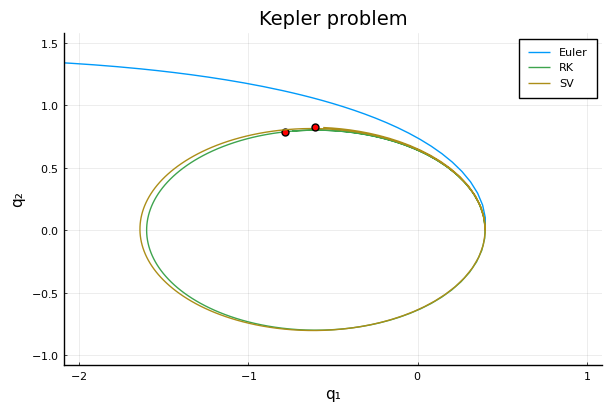

┌ Info: Saved animation to 
│   fn = /Users/kitanotomoya/Documents/julia/機械学習/figs-HMC/anim_KP.gif
└ @ Plots /Users/kitanotomoya/.julia/packages/Plots/HcxwM/src/animation.jl:114


Plots.AnimatedGif("/Users/kitanotomoya/Documents/julia/機械学習/figs-HMC/anim_KP.gif")
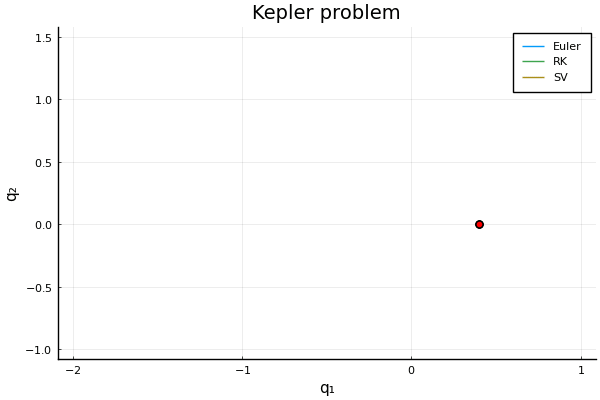

In [3]:
#potentiol energy
U(q) = -1/norm(q)

#kinetic energy
K(p) = norm(p)^2/2

#calculate Hamiltonian
H(q, p, U, K) = U(q) + K(p)

#set the parameters and initialize
T = 150
h = 0.05
qvec_init = [0.4, 0.0]
pvec_init = [0.0, 2.0]

#simulate Hamilton dynamics using explicit Euler method
qvecs_E, pvecs_E = simHamilton(T, h, x->∇Urev(U,x), qvec_init, pvec_init, myEuler)

#simulate Hamilton dynamics using RK method
qvecs_RK, pvecs_RK = simHamilton(T, h, x->∇Urev(U,x), qvec_init, pvec_init, myRK)

#simulate Hamilton dynamics using Srörmer-Verlet method
qvecs_SV, pvecs_SV = simHamilton(T, h, x->∇Urev(U,x), qvec_init, pvec_init, myStörmerVerlet)

#animation
anim_KP = @animate for t in 1:T
    plot(title="Kepler problem", xlim=[-2,1], ylim=[-1,1.5], xlabel="q₁", ylabel="q₂")
    
    #Euler
    plot!(qvecs_E[1,1:t-1], qvecs_E[2,1:t-1], label="Euler")
    plot!([qvecs_E[1,t]], [qvecs_E[2,t]], st=:scatter, color=:red, markersize=5, label=false)
    
    #Runge-Kutta
    plot!(qvecs_RK[1,1:t-1], qvecs_RK[2,1:t-1], label="RK")
    plot!([qvecs_RK[1,t]], [qvecs_RK[2,t]], st=:scatter, color=:red, markersize=5, label=false)
    
    #Störmer-Verlet
    plot!(qvecs_SV[1,1:t-1], qvecs_SV[2,1:t-1], label="SV")
    plot!([qvecs_SV[1,t]], [qvecs_SV[2,t]], st=:scatter, color=:red, markersize=5, label=false)
end
gif(anim_KP, "figs-HMC/anim_KP.gif")

In [ ]:
#set the parameters and initialize
T = 10000
h = 0.05
qvec_init = [0.4, 0.0]
pvec_init = [0.0, 2.0]

#simulate Hamilton dynamics using explicit Euler method
qvecs_E, pvecs_E = simHamilton(T, h, x->∇Urev(U,x), qvec_init, pvec_init, myEuler)

#simulate Hamilton dynamics using RK method
qvecs_RK, pvecs_RK = simHamilton(T, h, x->∇Urev(U,x), qvec_init, pvec_init, myRK)

#simulate Hamilton dynamics using Srörmer-Verlet method
qvecs_SV, pvecs_SV = simHamilton(T, h, x->∇Urev(U,x), qvec_init, pvec_init, myStörmerVerlet)

#calculate Hamiltonian
exactH = H(qvec_init, pvec_init, U, K)
Herror_E = zeros(T) 
Herror_RK = zeros(T)
Herror_SV = zeros(T)
for t in 1:T
    Herror_E[t] = abs(H(qvecs_E[:,t], pvecs_E[:,t], U, K)-exactH)
    Herror_RK[t] = abs(H(qvecs_RK[:,t], pvecs_RK[:,t], U, K)-exactH)
    Herror_SV[t] = abs(H(qvecs_SV[:,t], pvecs_SV[:,t], U, K)-exactH)
end

#plot Hamiltonian
fig1 = plot(title="Error of Hamiltonian", xlabel="iter", ylabel="error of H(q,p)", lw=0.1, xscale=:log10, yscale=:log10, ylim=[1e-6,1e0])
plot!(1:T, Herror_E, label="Euler")
plot!(1:T, Herror_RK, label="RK")
plot!(1:T, Herror_SV, label="SV")
savefig(fig1, "figs-HMC/fig1.png")

## 位置空間の様子

In [ ]:
#2次元正規分布
logp(x,y) = logpdf(MvNormal([0.0, 0.0], [1.0 0.0; 0.0 1.0]), [x,y])

#プロット
xs = -4:0.1:4
ys = -4:0.1:4
fig0 = plot(xs, ys, logp, st=:surface, alpha=0.8, colorbar=false)
savefig(fig0, "figs-HMC/fig0.png")

In [ ]:
#2次元正規分布のpdfの符号反転
logprev(x,y) = -logpdf(MvNormal([0.0, 0.0], [1.0 0.0; 0.0 1.0]), [x,y])

#プロット
fig00 = plot(xs, ys, logprev, st=:surface, alpha=0.8, colorbar=false)
savefig(fig00, "figs-HMC/fig00.png")

In [ ]:
#create animation
function create_anim1(filename, qvecs, T)
    xs = -4:0.1:4
    ys = -4:0.1:4
    logprevs = zeros(T)
    qvec = zeros(2)
    anim = @animate for t in 1:T
        qvec = qvecs[:,t]
        logprevs[t] = logprev(qvec[1], qvec[2])
        plot(xs, ys, logprev, st=:surface, alpha=0.5, colorbar=false, camera=(100, 35), xlabel="q₁", ylabel="q₂")
        plot!(qvecs[1,1:t-1], qvecs[2,1:t-1], logprevs[1:t-1], st=:scatter, label=false, markerstrokewidth=0, markersize=3, color=:black, title="iter=$(t)")
        plot!([qvecs[1,t]], [qvecs[2,t]], [logprevs[t]], st=:scatter, label=false, markerstrokewidth=0, markersize=6, color=:red)
    end
    gif(anim, filename)
end

#potentiol energy
U(q) = logprev(q[1], q[2])

#set the parameters and initialize
T = 150
h = 0.05
qvec_init = -3*ones(2)
pvec_init = ones(2)

#simulate Hamilton dynamics using Runge-Kutta method
qvecs, pvecs = simHamilton(T, h, x->∇Urev(U,x), qvec_init, pvec_init, myRK)
create_anim1("figs-HMC/anim1.gif", qvecs, T)

## HMCの実装

In [4]:
#update the position
function update(T, h, f, qvec, pvec)
    qvec_new = qvec
    pvec_new = pvec
    for t in 1:T
        qvec_new, pvec_new = myStörmerVerlet(qvec_new, pvec_new, h, f)
    end
    return qvec_new, pvec_new
end

#MH acceptance and rejection
function accept_or_reject(xvec, xvec_old, pvec, pvec_old, H)
    ΔH = H(xvec, pvec)-H(xvec_old, pvec_old)
    α = min(1.0, exp(-ΔH))
    u = rand()
    if u≤α
        return xvec, pvec
    else
        return xvec_old, pvec_old
    end
end

#Hamiltonian Monte Carlo
function myHMC(x₀, n_samps, n_burnin, pdf_func, T, h)
    #initialization
    d = length(x₀)
    xsamps = zeros(d, n_samps)
    xsamps[:,1] = x₀
    xvec = zeros(d)
    pvec = zeros(d)
    
    #Hamiltonian
    U(xvec) = -log(pdf_func(xvec))
    ∇Uneg(xvec) = -ForwardDiff.gradient(U, xvec)
    H(xvec, pvec) = U(xvec) + norm(pvec)^2/2
    
    #sample
    xvec_old = x₀
    pvec_old = randn(d)
    for i in 2:n_samps
        pvec = randn(d)
        xvec, pvec = update(T, h, ∇Uneg, xvec, pvec)
        xvec, pvec = accept_or_reject(xvec, xvec_old, pvec, pvec_old, H)
        xsamps[:,i] = xvec
        xvec_old = xvec
        pvec_old = pvec
    end
    return xsamps[:,n_burnin:end]
end

#HMC for hierarchical model
function HMC_hm(λ₀, β₀, n_samps, n_burnin, T, h, Y, N, α, μβ)
    #initialization
    λsamps = zeros(N,n_samps)
    βsamps = zeros(n_samps)
    λsamps[:,1] = λ₀
    βsamps[1] = β₀
    λvec = zeros(N)
    pvec = zeros(N)
    
    #Hamiltonian
    pdf_func(xvec) = exp(dot(Y+(α+1)*ones(N), log.(xvec)))
    U(xvec) = -log(pdf_func(xvec))
    ∇Uneg(xvec) = -ForwardDiff.gradient(U, xvec)
    H(xvec, pvec) = U(xvec) + norm(pvec)^2/2
    
    #sample
    λvec_old = λ₀
    pvec_old = randn(N)
    for i in 2:n_samps
        #sample using leap frog
        pvec = randn(N)
        λvec, pvec = update(T, h, ∇Uneg, λvec, pvec)
        λvec, pvec = accept_or_reject(λvec, λvec_old, pvec, pvec_old, H)
        λsamps[:,i] = λvec
        λvec_old = λvec
        pvec_old = pvec
        
        #saple using Gibbs sampler
        βsamps[i] = rand(Gamma(α*N+1, 1/(N+μβ)))
    end
    return λsamps[:,n_burnin:end], βsamps[n_burnin:end]
end

HMC_hm (generic function with 1 method)

## 例1: 正規分布からのサンプル

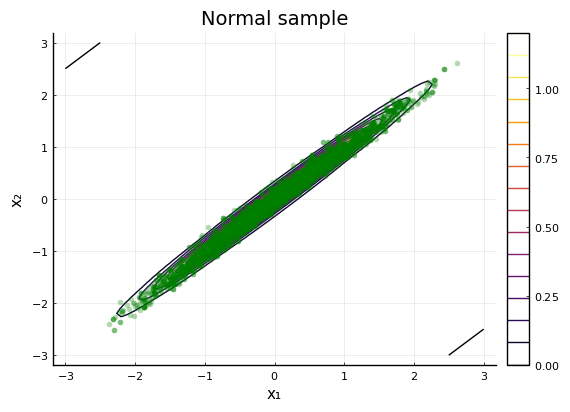

In [22]:
#multivariate Normal distribution
μ = [0.0, 0.0]
Σ = [1.0 0.99; 0.99 1.0]
mv_normal = MvNormal(μ, Σ)
pdf_func(x) = pdf(mv_normal, x)

#sample from multivariate normal distribution
x₀ = zeros(2)
n_samps = 5000
n_burnin = div(n_samps,10)
T = 100
h = 0.05
xsamps = myHMC(x₀, n_samps, n_burnin, pdf_func, T, h)

#visualize
x1s = -3:0.1:3
x2s = -3:0.1:3
fig2 = plot(x1s, x2s, (x,y)->pdf_func([x,y]), st=:contour, xlim=[-3,3], ylim=[-3,3], xlabel="x₁", ylabel="x₂", title="Normal sample")
plot!(xsamps[1,:], xsamps[2,:], st=:scatter, label=false, alpha=0.3, markerstrokewidth=0, color=:green)
savefig(fig2, "figs-HMC/fig2.png")

## 例2. 混合正規分布からのサンプル

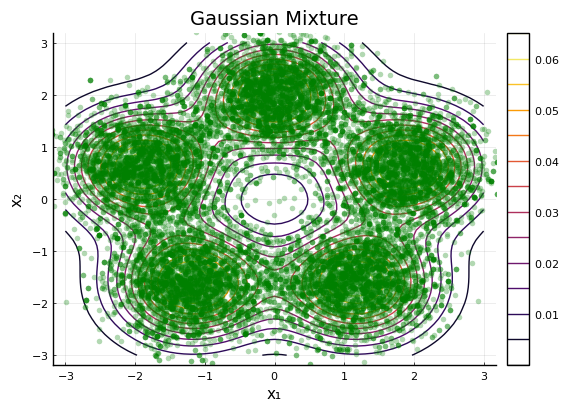

In [9]:
#Guassian mixture 
θ = 2*π/5
μ_func(i, θ) = 2*[cos(π/10+i*θ), sin(π/10+i*θ)]
Σ = I(2)/2
μ₀ = μ_func(0, θ)
μ₁ = μ_func(1, θ)
μ₂ = μ_func(2, θ)
μ₃ = μ_func(3, θ)
μ₄ = μ_func(4, θ)
mixed_normal = MixtureModel([MvNormal(μ₀, Σ), MvNormal(μ₁, Σ), MvNormal(μ₂, Σ), MvNormal(μ₃, Σ), MvNormal(μ₄, Σ)])
pdf_func(x) = pdf(mixed_normal, x)

#sample from Gussian mixture distribution
x₀ = zeros(2)
n_samps = 20000
n_burnin = div(n_samps,10)
T = 100
h = 0.05
xsamps = myHMC(x₀, n_samps, n_burnin, pdf_func, T, h)

#visualize
x1s = -3:0.1:3
x2s = -3:0.1:3
fig3 = plot(x1s, x2s, (x,y)->pdf_func([x,y]), st=:contour, xlim=[-3,3], ylim=[-3,3], xlabel="x₁", ylabel="x₂", title="Gaussian Mixture")
plot!(xsamps[1,:], xsamps[2,:], st=:scatter, label=false, alpha=0.3, markerstrokewidth=0, color=:green)
savefig(fig3, "figs-HMC/fig3.png")